# Search for orientation of image of HD160617 with astrometry.net


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : October 5th 2021
- version v0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [102]:
from iminuit import Minuit
import iminuit

In [103]:
iminuit.__version__

'2.7.0'

In [104]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [105]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [106]:
from distutils.dir_util import copy_tree

In [107]:
from astropy.visualization import simple_norm

In [108]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [109]:
from astroquery.simbad import Simbad
#import astropy.coordinates as coord

import astropy.units as u

In [110]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table

# Configuration

In [111]:
FLAG_REMOVE_WCS=False

# Path

In [112]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [113]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [114]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [115]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [116]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [117]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [118]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_v3.0.csv'

In [119]:
df=pd.read_csv(filename_logbook,index_col=0)

In [120]:
pd.set_option('display.max_rows', None)

In [121]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2100.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [122]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [123]:
#idx=76
#idx=96
idx=109

In [124]:
target_name="HD160617"

In [125]:
sky_coord_target=SkyCoord.from_name(target_name)
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (265.705515, -40.32097381)>

In [126]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits


In [127]:
print(df.iloc[idx])

index                                                        109
date                                     2021-07-08T05:07:18.207
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000350_quick...
num                                                          350
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.089964
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.5
humidity                                                     6.0
windspd                  

In [128]:
myhome=os.getenv("HOME")

In [129]:
dir_images=path_images

In [130]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits'

In [131]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [132]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [133]:
FLAG_ORDER0_LOCATION=False

In [134]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

NO Order 0 location from logbook ! 


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [135]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000350_quickLookExp'

In [136]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [137]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [138]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000350_quickLookExp'

# Configuration of the Spectractor running mode

In [139]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [140]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- the image fits format extracted from quickLookExp images at NCSA has not the exact format required by Spectractor.

In [141]:
from shutil import copyfile

In [142]:
copyfile(filename,filename_image)

'holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits'

In [143]:
from astropy.io import fits

In [144]:
hdu = fits.open(filename_image)

In [145]:
hdu.info()

Filename: holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [146]:
# extract header and the image
header=hdu[0].header
image=hdu[0].data

In [147]:
hdu.close()

## Rotate image

- rotate the image according what is expected in Spectractor

In [148]:
#rot_image=np.flip(np.flip(image, 1), 0)
rot_image=np.flip(image, 0)

### Remove WCS

- may not be necessary

In [149]:
if FLAG_REMOVE_WCS:
    del header['WCSAXES']
    del header['CTYPE1']
    del header['CTYPE2']
    del header['CUNIT1']
    del header['CUNIT2']
    del header['CRVAL1']
    del header['CRVAL2']
    del header['CRPIX1']
    del header['CRPIX2']

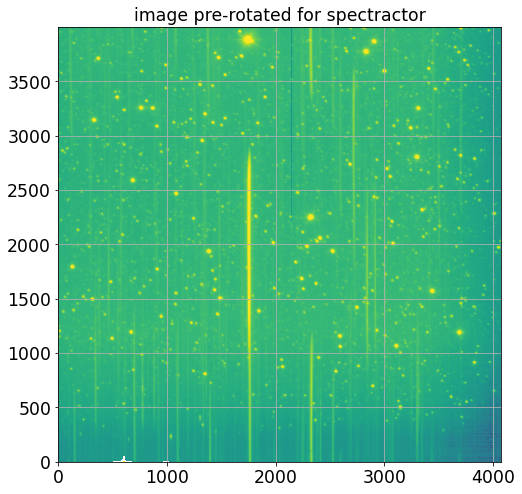

In [150]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.imshow(rot_image,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
ax.set_title("image pre-rotated for spectractor")
plt.show()

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [151]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [152]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [153]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     123   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [154]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new image file with Spectractor

In [155]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [156]:
parameters.OBS_NAME

'AUXTEL'

In [157]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [158]:
parameters.DISTANCE2CCD

182.0

In [159]:
parameters.LAMBDA_MIN 

300

In [160]:
parameters.LAMBDA_MAX 

1100

In [161]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [162]:
image.filter_label

''

In [163]:
image.header["FILTER"]

'empty_1'

In [164]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

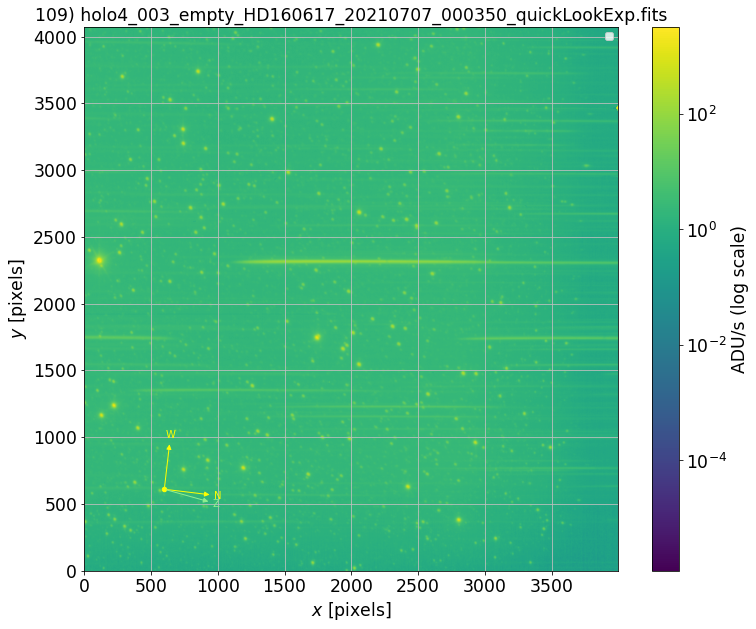

In [165]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

In [166]:
# with filter
guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits


# wide scan
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][18] , holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][19] , holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][20] , holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][21] , holo4_003_empty_HD160617_20210707_000255_quickLookExp.fits

#

# narrrow scan

guess = [500.,2100.] # filename_image=df['file'][76] , 'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'
guess = [500.,2100.] # filename_image=df['file'][77] , 'holo4_003_empty_HD160617_20210707_000318_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][78] , 'holo4_003_empty_HD160617_20210707_000319_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][79] , 'holo4_003_empty_HD160617_20210707_000320_quickLookExp.fits'
guess = [500.,1300.] # filename_image=df['file'][80] , 'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [167]:
filename_image

'holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits'

In [168]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

# Open image in astropy

In [169]:
sky_coord_target

<SkyCoord (ICRS): (ra, dec) in deg
    (265.705515, -40.32097381)>

In [170]:
hdu = fits.open(filename_image)

In [171]:
header=hdu[0].header
image=hdu[1].data

In [172]:
wcs = WCS(header)

2021-10-05 17:36:17  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-05 17:36:17  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


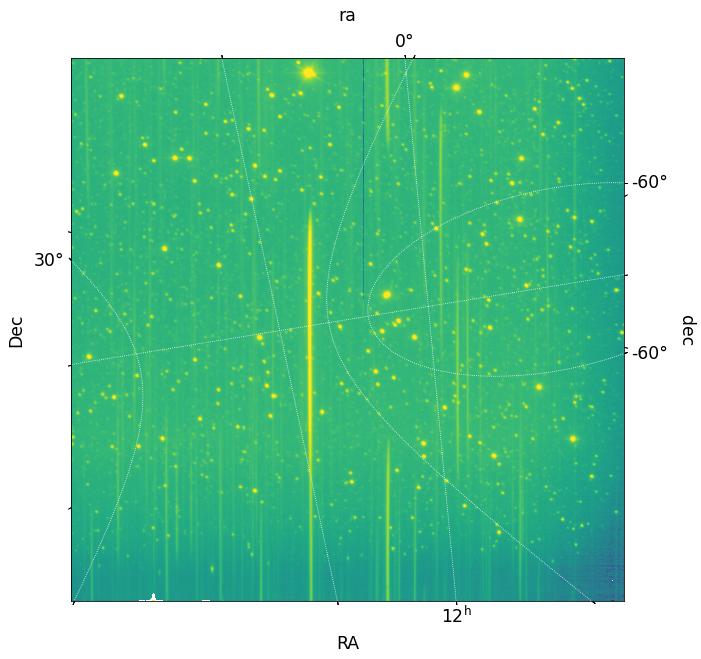

In [173]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
plt.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

# Work with astrometry.net

In [174]:
FLAG_RESULTS_ASTROMETRY_NET=True
DIR_RESULT_ASTROMETRY_NET="astrometry_HD160617"

In [175]:
file_new_image="new-image.fits" # New FITS image
file_axy="axy.fits"             # Stars detected in your images (x,y table) 
file_wcs="wcs.fits"             # WCS file
file_corr="corr.fits"           # Correspondences between image and reference stars
file_rdls="rdls.fits"           # Reference stars nearby (RA,Dec table):

In [176]:
fullfile_new_image=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_new_image)
fullfile_wcs=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_wcs)
fullfile_axy=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_axy)
fullfile_rdls=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_rdls)
fullfile_corr=os.path.join(DIR_RESULT_ASTROMETRY_NET,file_corr)

## The astrometry.net image

In [177]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu = fits.open(fullfile_new_image)
    hdu.info()

Filename: astrometry_HD160617/new-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     340   (4072, 4000)   float32   


In [178]:
if FLAG_RESULTS_ASTROMETRY_NET:
    header=hdu[0].header
    image=hdu[0].data
    wcs = WCS(header)
    print(wcs)

Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-05 17:36:19  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 265.672047969  -40.2863611164  
CRPIX : 1497.93281555  2091.68786621  
CD1_1 CD1_2  : 2.22395826596e-05  -1.43239061305e-05  
CD2_1 CD2_2  : 1.43944764864e-05  2.24269812216e-05  
NAXIS : 4072  4000


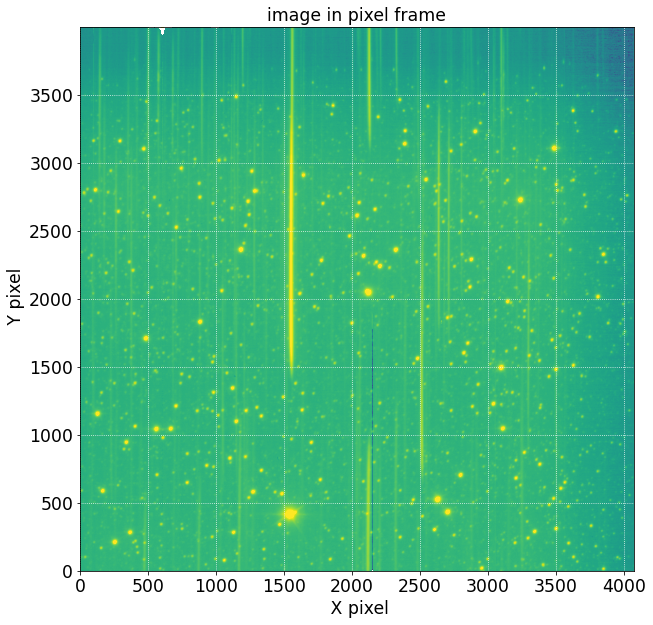

In [179]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.imshow(image, origin="lower",aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r' X pixel')
    ax.set_ylabel(r' Y pixel')


    ax.grid(color='white', ls='dotted')
    ax.set_title("image in pixel frame")

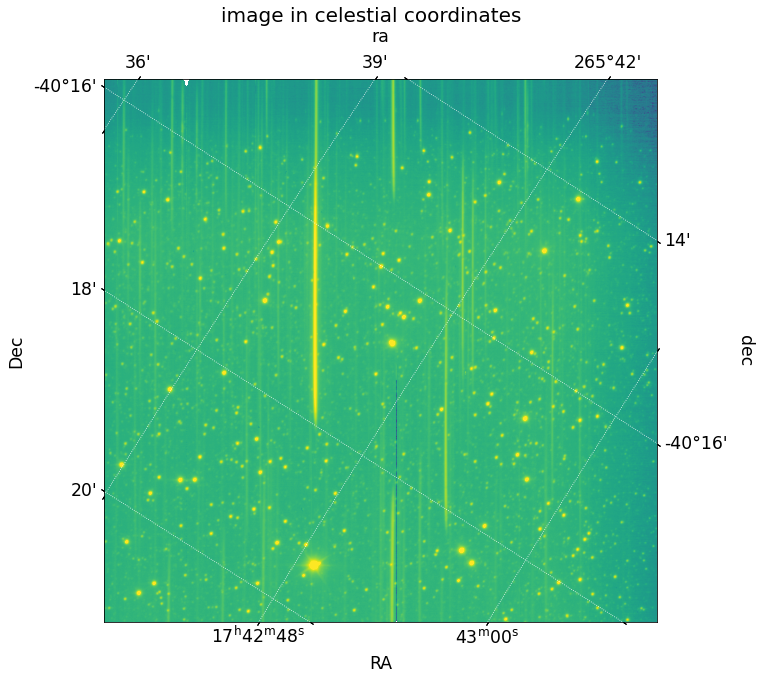

In [180]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    ax.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')

    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')
    
    plt.suptitle("image in celestial coordinates",fontsize=20)
    

## WCS coordinates

In [181]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_wcs = fits.open(fullfile_wcs)
    hdu_wcs.info()
    hdu = hdu_wcs[0]
    wcs_astrometry = WCS(hdu.header)
    print(wcs_astrometry)

Filename: astrometry_HD160617/wcs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   ()      


2021-10-05 17:36:23  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 265.672047969  -40.2863611164  
CRPIX : 1497.93281555  2091.68786621  
CD1_1 CD1_2  : 2.22395826596e-05  -1.43239061305e-05  
CD2_1 CD2_2  : 1.43944764864e-05  2.24269812216e-05  
NAXIS : 0  0


## Stars detected in your images (x,y table) 

In [182]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_axy = fits.open(fullfile_axy)
    hdu_axy.info()

Filename: astrometry_HD160617/axy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1                1 BinTableHDU     16   1000R x 4C   [E, E, E, E]   


In [183]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_axy = Table.read(fullfile_axy, hdu=1)  

In [184]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_axy.show_in_notebook()
    print(t_axy)

    X         Y        FLUX   BACKGROUND
--------- --------- --------- ----------
1541.8807 409.39954  52048.25  50.035156
606.57074 3997.0195 39308.727  16.285156
2120.5078 2048.3599 28847.809  47.515625
3237.0881 2729.4512 13547.363   48.83008
3095.5752 1496.2555 12983.413  44.816406
 255.7404  213.9769  8733.642   44.52539
 1182.721 2364.2222  8527.674  48.121094
3107.9167 1048.5535  6629.203  44.081543
2386.7432 3141.6191 3288.7654   39.86499
1550.4786 424.86862  33285.46  50.035156
      ...       ...       ...        ...
37.688934 3498.7322 26.941006  23.591393
3813.3132 1936.1526 73.488655  26.668312
3414.9724 1125.9885  71.90456  40.247223
 2076.848 197.45708 57.811237   50.13963
805.10565 33.985363 58.154346  44.108006
650.09235 1574.7004 59.606762  40.944508
2084.1248 1732.0671 50.189053  43.716114
 2911.131  2963.522 27.490955  45.576344
1877.4156 2674.2002  24.80104  46.825096
 797.8622 2846.3418 22.017735  45.819485
2939.2786 1928.0398  68.05586  45.762245
Length = 1000 ro

##  Reference stars nearby (RA,Dec table):

In [185]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_rdls = fits.open(fullfile_rdls)
    hdu_rdls.info()

Filename: astrometry_HD160617/rdls.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1                1 BinTableHDU     16   42R x 2C   [1D, 1D]   


In [186]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_rdls = Table.read(fullfile_rdls, hdu=1)  

In [187]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_rdls.show_in_notebook()
    print(t_rdls)

        RA                 DEC        
       deg                 deg        
------------------ -------------------
 265.7057130599642  -40.32001861689888
 265.7379194510254  -40.30591111337093
  265.740894432308  -40.26557778545993
265.70132500591876 -40.317644428394615
265.71133890324006  -40.23501944438766
 265.6575694316007  -40.25176665075496
 265.6344333456929  -40.26036387208002
265.70003055368704  -40.22014168258268
265.67804444443834  -40.24989722464883
265.72970000843037 -40.276633319026196
               ...                 ...
265.68124165038796  -40.32390834714365
 265.7600777685953  -40.29316388503898
 265.7081472096811  -40.26223334263313
 265.7362527767159   -40.2987055585179
 265.6494833328385 -40.326972227859784
265.64086389833665  -40.27216942993895
  265.691148874979 -40.278493342303356
 265.6578500111267  -40.28463331761367
 265.6900055587149 -40.272861112379296
 265.6493555412315 -40.309463901416876
Length = 42 rows


In [188]:
NrefStars=len(t_rdls)

In [189]:
all_sep=np.zeros(NrefStars)
for idx in np.arange(NrefStars):
    the_ra=t_rdls[idx]['RA']
    the_dec=t_rdls[idx]['DEC']
    skyc=SkyCoord(ra=the_ra, dec=the_dec,frame='icrs',unit=(u.deg, u.deg))
    sep = sky_coord_target.separation(skyc).arcsec 
   
    all_sep[idx]=sep
    
    print(">>>>>>>>>>",the_ra,the_dec,sep)
    result_table = Simbad.query_region(skyc,radius=5./3600. * u.deg)
    if result_table != None :
        print(result_table)
    else:
        print("Reference star not found")
       

>>>>>>>>>> 265.7057130599642 -40.32001861689888 3.4814016702810155


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350                1
>>>>>>>>>> 265.7379194510254 -40.30591111337093 104.17731121547622


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:57.1007 -40:18:21.28': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.740894432308 -40.26557778545993 221.82936758648367


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:57.8147 -40:15:56.08': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.70132500591876 -40.317644428394615 16.61104487930509


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:48.318 -40:19:03.5199': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.71133890324006 -40.23501944438766 309.84885595600934


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.7213 -40:14:06.07': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6575694316007 -40.25176665075496 281.79708239017845


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.8167 -40:15:06.3599': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6344333456929 -40.26036387208002 292.7596196060346


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:32.264 -40:15:37.3099': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.70003055368704 -40.22014168258268 363.3081239124025


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:48.0073 -40:13:12.5101': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.67804444443834 -40.24989722464883 266.76488762795043


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.7307 -40:14:59.63': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.72970000843037 -40.276633319026196 172.88676533157673


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:55.128 -40:16:35.8799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.73695001503427 -40.24723054063508 279.15942749603863


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:56.868 -40:14:50.0299': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.61735554669616 -40.291336127968776 264.5033545816017


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:28.1653 -40:17:28.8101': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6731638926823 -40.24340554995668 293.03913059229166


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.5593 -40:14:36.26': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6661833232753 -40.323374984549474 108.29936784155524


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


        MAIN_ID               RA      ... Z_VALUE_2 SCRIPT_NUMBER_ID
                           "h:m:s"    ...                           
----------------------- ------------- ... --------- ----------------
2MASS J17423946-4019240 17 42 39.4701 ...        --                1
>>>>>>>>>> 265.6873166673495 -40.25385276990208 246.74948536567595


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:44.956 -40:15:13.87': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.69402779394187 -40.32380556576873 33.136006098942175


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:46.5667 -40:19:25.7': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7496360996528 -40.29385001065416 155.58326467544669


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:59.9127 -40:17:37.86': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.67183056284017 -40.31456665983106 95.29351694744355


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.2393 -40:18:52.44': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.72256387373767 -40.22566109382118 346.3064495909554


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:53.4153 -40:13:32.3799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6855361106894 -40.27290832048829 181.52307174837586


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:44.5287 -40:16:22.47': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.69975557011617 -40.3209444428689 15.808571986290545


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:47.9413 -40:19:15.4': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.65894168206563 -40.3010833493378 146.53762087013473


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.146 -40:18:03.9001': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.65284721789004 -40.27374723156573 223.19847980602407


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6833 -40:16:25.49': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.76003332989677 -40.289799993975514 187.07457135687517


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:43:02.408 -40:17:23.28': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6526555639742 -40.276005559167395 217.4189023307563


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6373 -40:16:33.62': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.67770000885514 -40.26685000593219 209.2800026536787


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.648 -40:16:00.66': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7342111258029 -40.28369721697403 155.61379896919146


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:56.2107 -40:17:01.31': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.69121389246953 -40.26832778377564 193.55099862689792


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.8913 -40:16:05.98': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.660030551652 -40.32911110193939 128.22713302719677


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.4073 -40:19:44.8': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7422472350787 -40.27160832611502 204.34082994333002


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:58.1393 -40:16:17.79': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6610139029643 -40.26569442944077 233.52686431658904


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.6433 -40:15:56.4999': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7110694613541 -40.24708334228984 266.44269026689676


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.6567 -40:14:49.5': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.68124165038796 -40.32390834714365 67.4553001810237


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:43.498 -40:19:26.07': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7600777685953 -40.29316388503898 180.1689680672269


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:43:02.4187 -40:17:35.39': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7081472096811 -40.26223334263313 211.58917159063841


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:49.9553 -40:15:44.04': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.7362527767159 -40.2987055585179 116.39064728694203


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


  MAIN_ID         RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
V* V533 Sco 17 42 56.7406 -40 17 55.490 ... -0.0000300                1
>>>>>>>>>> 265.6494833328385 -40.326972227859784 155.29498625324806


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.876 -40:19:37.1': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.64086389833665 -40.27216942993895 249.76135360851336


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:33.8073 -40:16:19.8099': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.691148874979 -40.278493342303356 157.9345027505983


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 324150 17 42 45.8819 -40 16 42.632 ...        --                1
>>>>>>>>>> 265.6578500111267 -40.28463331761367 185.04250122556448


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.884 -40:17:04.6799': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6900055587149 -40.272861112379296 178.36389690309406


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.6013 -40:16:22.3': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 265.6493555412315 -40.309463901416876 159.62862112347815


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.8453 -40:18:34.07': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found


In [190]:
all_sep

array([  3.48140167, 104.17731122, 221.82936759,  16.61104488,
       309.84885596, 281.79708239, 292.75961961, 363.30812391,
       266.76488763, 172.88676533, 279.1594275 , 264.50335458,
       293.03913059, 108.29936784, 246.74948537,  33.1360061 ,
       155.58326468,  95.29351695, 346.30644959, 181.52307175,
        15.80857199, 146.53762087, 223.19847981, 187.07457136,
       217.41890233, 209.28000265, 155.61379897, 193.55099863,
       128.22713303, 204.34082994, 233.52686432, 266.44269027,
        67.45530018, 180.16896807, 211.58917159, 116.39064729,
       155.29498625, 249.76135361, 157.93450275, 185.04250123,
       178.3638969 , 159.62862112])

In [191]:
idx_target=np.where(all_sep==np.min(all_sep))[0][0]
idx_target

0

## Correspondences between image and reference stars

In [192]:
if FLAG_RESULTS_ASTROMETRY_NET:
    hdu_corr = fits.open(fullfile_corr)
    hdu_corr.info()

Filename: astrometry_HD160617/corr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     47   40R x 13C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1J, 1D, 1E, 1E]   


In [193]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_corr = Table.read(fullfile_corr, hdu=1)  

In [194]:
if FLAG_RESULTS_ASTROMETRY_NET:
    t_corr.show_in_notebook()
    print(t_corr)

     field_x            field_y       ...    FLUX   BACKGROUND
      pixels             pixels       ...                     
------------------ ------------------ ... --------- ----------
      2120.5078125   2048.35986328125 ... 28847.809  47.515625
 3237.088134765625     2729.451171875 ... 13547.363   48.83008
   3095.5751953125 1496.2554931640625 ... 12983.413  44.816406
 1182.720947265625   2364.22216796875 ...  8527.674  48.121094
   2386.7431640625     3141.619140625 ... 3288.7654   39.86499
 3485.153564453125     3108.833984375 ... 12650.591  32.963867
128.86065673828125  1157.429931640625 ...  8547.412   39.49707
484.31402587890625  1711.683837890625 ... 7141.7393   42.09082
      2321.2265625  2362.871826171875 ...  6040.608  47.935547
 2797.019287109375  706.4255981445312 ... 5009.8105  45.145996
               ...                ... ...       ...        ...
  3939.26806640625   3233.35009765625 ... 665.12335  13.985107
340.39801025390625  947.3970336914062 ... 2948.1892   4

In [195]:
t_corr.show_in_notebook()

idx,field_x,field_y,field_ra,field_dec,index_x,index_y,index_ra,index_dec,index_id,field_id,match_weight,FLUX,BACKGROUND
,pixels,pixels,degrees,degrees,pixels,pixels,degrees,degrees,none,none,none,,
0,2120.5078125,2048.35986328125,265.69107699908307,-40.27836947675392,2119.7285467378624,2043.3356711326023,265.691148874979,-40.278493342303356,38,2,0.9973131651568761,28847.809,47.515625
1,3237.088134765625,2729.451171875,265.7109777493917,-40.24708779422811,3239.4169187409534,2728.156547403068,265.7110694613541,-40.24708334228984,31,3,0.9922942277480747,13547.363,48.83008
2,3095.5751953125,1496.2554931640625,265.7303167178282,-40.276706314463155,3082.3034279098706,1508.01319323254,265.72970000843037,-40.276633319026196,9,4,0.9896277289304031,12983.413,44.816406
3,1182.720947265625,2364.22216796875,265.6577594345874,-40.28478897663989,1188.0966472882246,2367.7313003221234,265.6578500111267,-40.28463331761367,39,6,0.9941660982668933,8527.674,48.121094
4,2386.7431640625,3141.619140625,265.67801847054324,-40.25013888620388,2392.4115795191365,3148.859148889964,265.67804444443834,-40.24989722464883,8,8,0.9925399329353324,3288.7654,39.86499
5,3485.153564453125,3108.833984375,265.7109614320955,-40.235088358853005,3495.6195427917337,3105.1672980564517,265.71133890324006,-40.23501944438766,4,10,0.9871698482579543,12650.591,32.963867
6,128.86065673828125,1157.429931640625,265.6495924911955,-40.327130554982865,129.34855307487464,1164.1399742717458,265.6494833328385,-40.326972227859784,36,11,0.983678592940436,8547.412,39.49707
7,484.31402587890625,1711.683837890625,265.64969803807895,-40.30949653810499,476.60541420529,1718.0712728063736,265.6493555412315,-40.309463901416876,41,12,0.9884951381297494,7141.7393,42.09082
8,2321.2265625,2362.871826171875,265.6910110174318,-40.26844046102533,2328.4267966886723,2363.2902316024974,265.69121389246953,-40.26832778377564,27,13,0.996468022788917,6040.608,47.935547


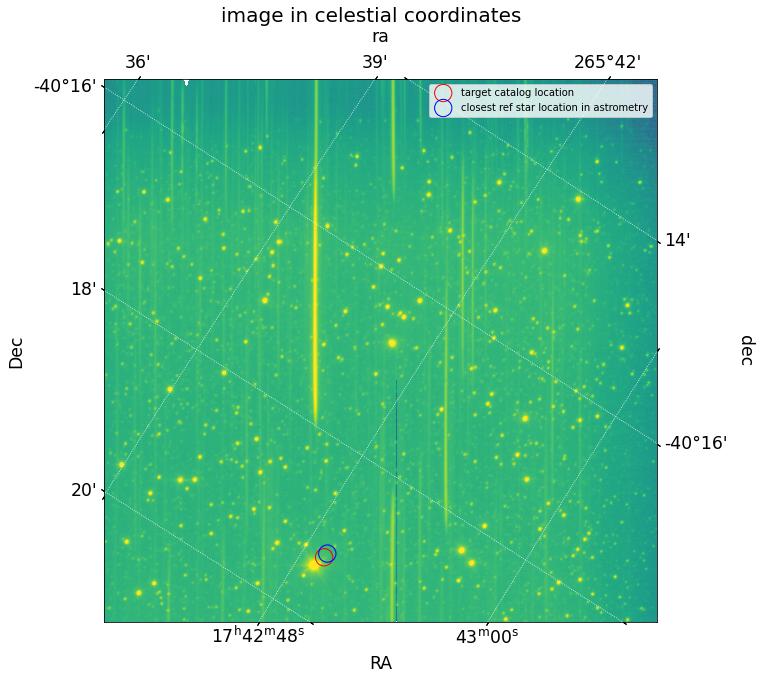

In [196]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    ax.imshow(image, aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')

    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')

    ax.scatter(sky_coord_target.ra.deg,sky_coord_target.dec.deg, transform=ax.get_transform('icrs'), s=300,edgecolor='red', facecolor='none',label="target catalog location")
    ax.scatter(t_rdls[idx_target]["RA"],t_rdls[idx_target]["DEC"], transform=ax.get_transform('icrs'), s=300,edgecolor='blue', facecolor='none',label="closest ref star location in astrometry")

    ax.legend()
    
    plt.suptitle("image in celestial coordinates",fontsize=20)

In [197]:
NrefStars=len(t_corr)
NrefStars

40

In [198]:
all_sep=np.zeros(NrefStars)+9999
for idx in np.arange(NrefStars):
    
    the_ra=t_corr[idx]['field_ra']
    the_dec=t_corr[idx]['field_dec']
    skyc=SkyCoord(ra=the_ra, dec=the_dec,frame='icrs',unit=(u.deg, u.deg))
    sep = sky_coord_target.separation(skyc).arcsec 
   
    all_sep[idx]=sep
    
    print(">>>>>>>>>>",idx," ra=",the_ra," dec=",the_dec," sep=",sep)
    result_table = Simbad.query_region(skyc,radius=5./3600. * u.deg)
    if result_table != None :
        print(result_table)
    else:
        print("Reference star not found")
       

>>>>>>>>>> 0  ra= 265.69107699908307  dec= -40.27836947675392  sep= 158.41560339405035


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 324150 17 42 45.8819 -40 16 42.632 ...        --                1
>>>>>>>>>> 1  ra= 265.7109777493917  dec= -40.24708779422811  sep= 266.4123880002642


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.6347 -40:14:49.5161': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 2  ra= 265.7303167178282  dec= -40.276706314463155  sep= 173.30248005730766


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:55.276 -40:16:36.1427': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 3  ra= 265.6577594345874  dec= -40.28478897663989  sep= 184.82296092695205


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.8623 -40:17:05.2403': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 4  ra= 265.67801847054324  dec= -40.25013888620388  sep= 265.95073729468515


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.7244 -40:15:00.5': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 5  ra= 265.7109614320955  dec= -40.235088358853005  sep= 309.5492643107739


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.6307 -40:14:06.3181': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 6  ra= 265.6495924911955  dec= -40.327130554982865  sep= 155.07856107432846


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.9022 -40:19:37.67': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 7  ra= 265.64969803807895  dec= -40.30949653810499  sep= 158.69021721958535


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:35.9275 -40:18:34.1875': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 8  ra= 265.6910110174318  dec= -40.26844046102533  sep= 193.26782744862928


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.8426 -40:16:06.3857': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 9  ra= 265.73620666845505  dec= -40.29881427864536  sep= 116.02942122215671


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


  MAIN_ID         RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
V* V533 Sco 17 42 56.7406 -40 17 55.490 ... -0.0000300                1
>>>>>>>>>> 10  ra= 265.7087030400016  dec= -40.2620393195041  sep= 212.34469448277474


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:50.0887 -40:15:43.3416': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 11  ra= 265.65257242680076  dec= -40.273692952654365  sep= 223.83665024123474


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6174 -40:16:25.2946': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 12  ra= 265.6876613429844  dec= -40.253732250942825  sep= 246.98475448865048


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.0387 -40:15:13.4361': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 13  ra= 265.66417457519935  dec= -40.32344103890835  sep= 113.81430317809782


/users/dagoret/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3189: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = (self.as_array().data == other) & (self.mask == false_mask)


        MAIN_ID               RA      ... Z_VALUE_2 SCRIPT_NUMBER_ID
                           "h:m:s"    ...                           
----------------------- ------------- ... --------- ----------------
2MASS J17423946-4019240 17 42 39.4701 ...        --                1
>>>>>>>>>> 14  ra= 265.6898611123815  dec= -40.27281735530387  sep= 178.6118999269991


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:45.5667 -40:16:22.1425': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 15  ra= 265.6589882695876  dec= -40.30103010659099  sep= 146.51992484131637


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.1572 -40:18:03.7084': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 16  ra= 265.733632049131  dec= -40.28351070055271  sep= 155.3973847009767


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:56.0717 -40:17:00.6385': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 17  ra= 265.61871374991347  dec= -40.2903144836415  sep= 262.6218156417236


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:28.4913 -40:17:25.1321': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 18  ra= 265.6607368482635  dec= -40.2659555786697  sep= 233.12643784308256


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.5768 -40:15:57.4401': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 19  ra= 265.73841967333016  dec= -40.30635270226742  sep= 104.54258306852222


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:57.2207 -40:18:22.8697': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 20  ra= 265.68491166679127  dec= -40.27285121198534  sep= 182.2439811649982


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:44.3788 -40:16:22.2644': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 21  ra= 265.67787675542905  dec= -40.26690006718079  sep= 208.9354431071519


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:42.6904 -40:16:00.8402': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 22  ra= 265.6998569129398  dec= -40.320899880042134  sep= 15.532342868822699


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:47.9657 -40:19:15.2396': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 23  ra= 265.73683394321955  dec= -40.24721737533508  sep= 279.1061074597153


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:56.8401 -40:14:49.9826': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 24  ra= 265.652593568232  dec= -40.27607700334648  sep= 217.34117803165256


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:36.6225 -40:16:33.8772': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 25  ra= 265.6354053241549  dec= -40.26021060367748  sep= 291.4010275339932


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:32.4973 -40:15:36.7582': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 26  ra= 265.69336329927825  dec= -40.32364232251412  sep= 34.708708477777506


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:46.4072 -40:19:25.1124': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 27  ra= 265.742559029163  dec= -40.27118787262939  sep= 206.0799519776707


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:58.2142 -40:16:16.2763': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 28  ra= 265.7487917034369  dec= -40.2934325472426  sep= 154.74430278041288


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:59.71 -40:17:36.3572': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 29  ra= 265.6572455558271  dec= -40.25144166682851  sep= 283.2472837196997


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:37.7389 -40:15:05.19': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 30  ra= 265.7219917934759  dec= -40.2258025120756  sep= 345.59274065865367


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:53.278 -40:13:32.889': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 31  ra= 265.6595408135959  dec= -40.32883355690643  sep= 129.31403757876564


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:38.2898 -40:19:43.8008': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 32  ra= 265.7600933606021  dec= -40.290378397713084  sep= 185.9651470325141


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:43:02.4224 -40:17:25.3622': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 33  ra= 265.75989067996034  dec= -40.29281909814192  sep= 180.43679560384274


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:43:02.3738 -40:17:34.1488': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 34  ra= 265.6407166462003  dec= -40.27244912155914  sep= 249.34215943783997


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:33.772 -40:16:20.8168': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 35  ra= 265.67985819932557  dec= -40.32417101800623  sep= 71.35435977510421


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:43.166 -40:19:27.0157': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 36  ra= 265.6731222647455  dec= -40.244814740975315  sep= 288.2439157297857


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.5493 -40:14:41.3331': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 37  ra= 265.7419281100119  dec= -40.26588117479012  sep= 222.1110650701997


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:58.0627 -40:15:57.1722': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 38  ra= 265.67237432945086  dec= -40.31463576227351  sep= 93.78514139388365


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:41.3698 -40:18:52.6887': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found
>>>>>>>>>> 39  ra= 265.7005847238707  dec= -40.22006090547296  sep= 363.53878543321525


/users/dagoret/anaconda3/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '17:42:48.1403 -40:13:12.2193': No astronomical object found :
  warnings.warn("Warning: The script line number %i raised "


Reference star not found


In [199]:
all_sep

array([158.41560339, 266.412388  , 173.30248006, 184.82296093,
       265.95073729, 309.54926431, 155.07856107, 158.69021722,
       193.26782745, 116.02942122, 212.34469448, 223.83665024,
       246.98475449, 113.81430318, 178.61189993, 146.51992484,
       155.3973847 , 262.62181564, 233.12643784, 104.54258307,
       182.24398116, 208.93544311,  15.53234287, 279.10610746,
       217.34117803, 291.40102753,  34.70870848, 206.07995198,
       154.74430278, 283.24728372, 345.59274066, 129.31403758,
       185.96514703, 180.4367956 , 249.34215944,  71.35435978,
       288.24391573, 222.11106507,  93.78514139, 363.53878543])

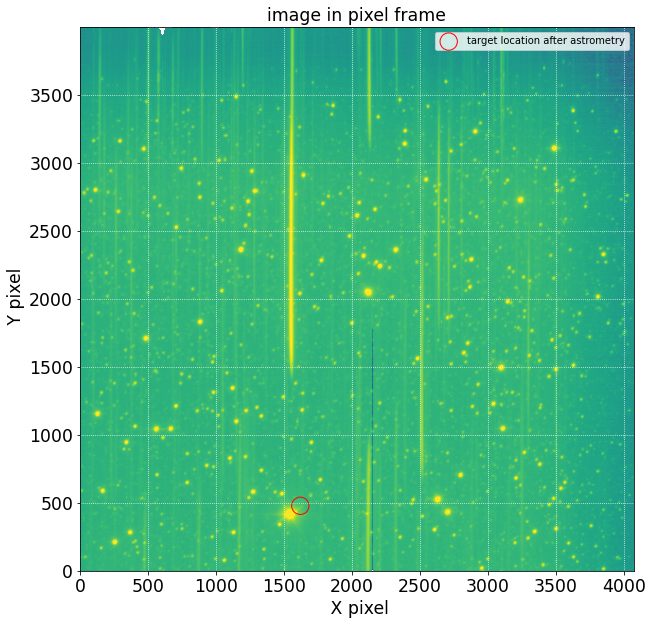

In [200]:
if FLAG_RESULTS_ASTROMETRY_NET:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.imshow(image, origin="lower",aspect='equal',norm=LogNorm(0.1,1000))
    ax.set_xlabel(r' X pixel')
    ax.set_ylabel(r' Y pixel')

    x0, y0 = wcs.world_to_pixel(sky_coord_target)
    ax.scatter(x0,y0, s=300,edgecolor='red', facecolor='none',label="target location after astrometry")

    ax.grid(color='white', ls='dotted')
    ax.set_title("image in pixel frame")
    ax.legend()